Warning this notebook requires to install the *DRFP* module:

-> can be install with : pip install drfp

-> alternative possibility are available on the git page: https://github.com/reymond-group/drfp

-> more details: https://pubs.rsc.org/en/content/articlehtml/2022/dd/d1dd00006c

In [1]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import rdChemReactions
from drfp import DrfpEncoder
from descriptors.preprocessing import preprocess, dict_ligand

In [2]:
# generate rection SMILES from NiCOlit
nicolit = pd.read_csv("data/NiCOlit.csv")
nicolit = preprocess(nicolit)

In [3]:
# featurize the reactions according to the DRFP method
import descriptors.drfp_featurization as drfp_ft

X_fp, y_fp, DOI_fp, mechanisms_fp, origins_fp = drfp_ft.process_dataframe(nicolit)

In [48]:
# test the performances
from analysis import analysis_train_set_size, random_split, stratified_split 

# random split
values, baseline_values, model_values, stratification_values, additional_stratification_values = random_split(X_fp, y_fp, origins_fp, mechanisms_fp, n_iterations=20)
display_df =  pd.DataFrame(zip(values, baseline_values, model_values, stratification_values, additional_stratification_values), 
                           columns = ['Yields', 'Baseline', 'Predicted Yields', 'Origin', 'Coupling Partner'])
display_df.to_csv("results/random_split_drfp_descriptors_test_size_0.2")

In [12]:
# substrate split (be carefull on the number of iterations)
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

metric = r2_score

values, global_baseline_results, global_results, stratification_results, additional_stratification_results = stratified_split(X_fp, y_fp, list(nicolit["substrate"]), origins_fp , metric=metric, predictor=RandomForestRegressor(), test_size=0.2, 
                                                                                                                              n_iterations=1)
display_df =  pd.DataFrame(zip(stratification_results, additional_stratification_results, global_results, global_baseline_results, values), columns =['Substrate', 'Origin', 'Predicted Yields', 'Global baseline', 'Yields'])
display_df.to_csv("results/substrate_split_drfp_descriptors")

In [13]:
# coupling partner split
values, global_baseline_results, global_results, stratification_results, additional_stratification_results = stratified_split(X_fp, y_fp, mechanisms_fp, origins_fp , metric=metric, predictor=RandomForestRegressor(), test_size=0.2, 
                                                                                                                              n_iterations=10)
display_df =  pd.DataFrame(zip(stratification_results, additional_stratification_results, global_results, global_baseline_results, values), columns =['Substrate', 'Origin', 'Predicted Yields', 'Global baseline', 'Yields'])
display_df.to_csv("results/mechanisms_split_drfp_descriptors")

### Visualize the results 

In [53]:
df = pd.read_csv('results/random_split_drfp_descriptors_test_size_0.2')

In [54]:
import seaborn as sns 
import matplotlib.pyplot as plt 
import matplotlib as mpl

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


RMSE =  23.536620087802465
MAE  =  17.10676287329069
R$^2$  =  0.5044979196893888


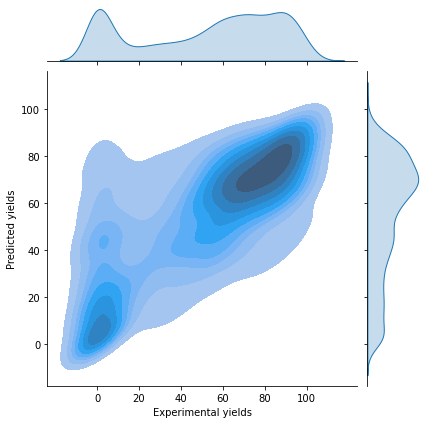

In [55]:
# random split
h = sns.jointplot("Yields", "Predicted Yields", df, kind='kde', fill=True)
h.set_axis_labels('Experimental yields', 'Predicted yields')
h.ax_joint.set_xticks([0, 20, 40, 60, 80, 100])
h.ax_joint.set_yticks([0, 20, 40, 60, 80, 100])

fig_path = 'images/random_split_drfp_descriptors_test_size_0.2_full.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight')

print('RMSE = ',mean_squared_error(df["Yields"], df["Predicted Yields"])**0.5)
print('MAE  = ',mean_absolute_error(df["Yields"], df["Predicted Yields"]))
print('R$^2$  = ',r2_score(df["Yields"], df["Predicted Yields"]))

In [56]:
R2 = []
for i in range(10):
    R2.append(r2_score(df["Yields"][i*282:(i+1)*282], df["Predicted Yields"][i*282:(i+1)*282]))
print(min(R2), np.mean(R2), np.std(R2), max(R2))

0.39623039777397484 0.49330374248798137 0.05113612680919473 0.5845341955648131
[0.5845341955648131, 0.4825685023227346, 0.4888871347240994, 0.4515972633823837, 0.4953561427511026, 0.39623039777397484, 0.5311195496664378, 0.45310335735522855, 0.5521306906702856, 0.4975101906687529]


In [58]:
# comparison with dft results:
df = pd.read_csv('results/random_split_dft_descriptors_test_size_0.2')
R2 = []
for i in range(10):
    R2.append(r2_score(df["Yields"][i*282:(i+1)*282], df["Predicted Yields"][i*282:(i+1)*282]))
print(min(R2), np.mean(R2), np.std(R2), max(R2))

0.45681887473663263 0.5370526879621498 0.05075776677174562 0.612527001644618


/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


RMSE =  29.567555126411136
MAE  =  22.78039759639907
R^2  =  0.21224072840874575


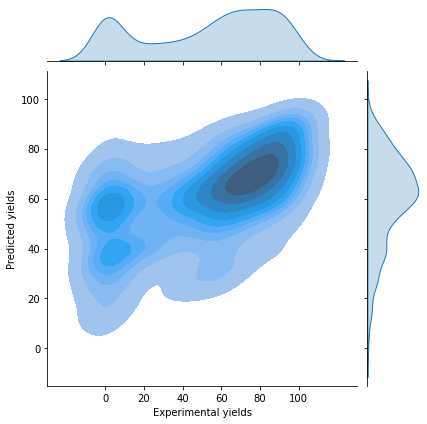

In [36]:
# substrate split
df = pd.read_csv('results/substrate_split_drfp_descriptors')

h = sns.jointplot("Yields", "Predicted Yields", df, kind='kde', fill=True)
h.set_axis_labels('Experimental yields', 'Predicted yields')
h.ax_joint.set_xticks([0, 20, 40, 60, 80, 100])
h.ax_joint.set_yticks([0, 20, 40, 60, 80, 100])
h.ax_marg_x.set_facecolor("white")
h.ax_marg_y.set_facecolor("white")
plt.savefig('images/substrate_split_drfp_descriptors_full.png', dpi=300, bbox_inches='tight')

print('RMSE = ',mean_squared_error(df["Yields"], df["Predicted Yields"])**0.5)
print('MAE  = ',mean_absolute_error(df["Yields"], df["Predicted Yields"]))
print('R^2  = ',r2_score(df["Yields"], df["Predicted Yields"]))

/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


RMSE =  34.67043772049323
MAE  =  29.113914087316445
R$^2$  =  -0.08313188933428606


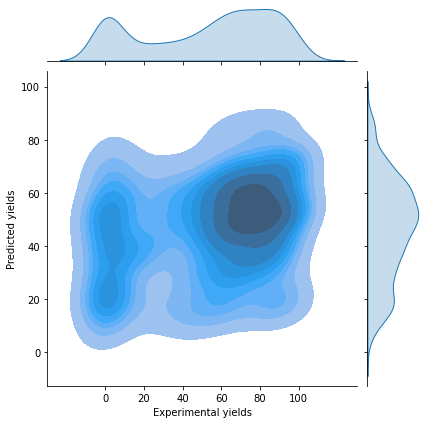

In [37]:
# coupling partner split
df = pd.read_csv('results/mechanisms_split_drfp_descriptors')

h = sns.jointplot("Yields", "Predicted Yields", df, kind='kde', fill=True)
h.set_axis_labels('Experimental yields', 'Predicted yields')
h.ax_joint.set_xticks([0, 20, 40, 60, 80, 100])
h.ax_joint.set_yticks([0, 20, 40, 60, 80, 100])
h.ax_marg_x.set_facecolor("white")
h.ax_marg_y.set_facecolor("white")
plt.savefig('images/mechanism_split_drfp_descriptors_full.png', dpi=300, bbox_inches='tight')

print('RMSE = ',mean_squared_error(df["Yields"], df["Predicted Yields"])**0.5)
print('MAE  = ',mean_absolute_error(df["Yields"], df["Predicted Yields"]))
print('R$^2$  = ',r2_score(df["Yields"], df["Predicted Yields"]))

In [61]:
# analysis of the DRFP performances on restricted datasets
import descriptors.dft_featurisation as dft_ft
nicolit_dft = pd.read_csv("data/NiCOlit.csv")
nicolit_dft = preprocess(nicolit_dft)
X_dft, y_dft, DOI_dft, mechanisms_dft, origins_dft, sub_dft, lig_dft = dft_ft.process_dataframe_dft(nicolit_dft, data_path="data/utils/", origin=False)

In [70]:
# substrate-split:
r2 = []
length = []
for sub in np.unique(sub_dft):
    indexes = np.where(sub_dft==sub)[0]
    values, baseline_values, model_values, stratification_values, additional_stratification_values = random_split(X_fp[indexes, :], y_dft[indexes], origins_dft[indexes], sub_dft[indexes], n_iterations=100)
    print(sub, len(indexes), round(r2_score(values, model_values), 3))
    r2.append(round(r2_score(values, model_values), 3))
    length.append(len(indexes))

OAc 72 0.389
OC(=O)N 215 0.295
OC(=O)O 82 0.636
OCH3 546 0.467
OCOC 17 -0.128
OPh 3 -1.551
OPiv 394 0.547
OSi(C)(C)C 23 -0.151
Otriazine 54 0.356


In [71]:
# coupling_partner-split:
r2 = []
length = []
for sub in np.unique(mechanisms_dft):
    indexes = np.where(mechanisms_dft==sub)[0]
    values, baseline_values, model_values, stratification_values, additional_stratification_values = random_split(X_fp[indexes, :], y_dft[indexes], origins_dft[indexes], mechanisms_dft[indexes], n_iterations=100)
    print(sub, len(indexes), round(r2_score(values, model_values), 3))
    r2.append(round(r2_score(values, model_values), 3))
    length.append(len(indexes))

Al 53 0.017
B 472 0.429
C-H 271 0.443
CO2 87 0.545
Li 52 -0.026
NCO 57 0.303
NH 27 -0.074
RMgX 266 0.371
Si 53 0.663
Zn 68 0.283
